**Logistic Regression With Mini-batch Gradient Descent**

<h2>Objective</h2>

<ul>
    <li>Represent your data as a Dataset object</li>
    <li>Create a Logistic Regression Model using PyTorch</li>
    <li>Set a Criterion to calculate Loss</li>
    <li>Create a Data Loader and set the Batch Size</li>
    <li>Create an Optimizer to update Model Parameters and set Learning Rate</li>
    <li>Train a Model</li>
</ul> 


<h2>Table of Contents</h2>
<p>Training a PyTorch Logistic Regression model using Mini-Batch Gradient Descent.</p>

<ul>
    <li>Load Data</li>
    <li>Create the Model and Total Loss Function (Cost)</li>
    <li>Setting the Batch Size using a Data Loader</li>
    <li>Setting the Learning Rate</li>
    <li>Train the Model via Mini-Batch Gradient Descent</li>
   
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>


Libraries:

In [1]:
#!pip3 install torch torchvision torchaudio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
#Create dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader
#pytorch Neural Network
import torch.nn as nn

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch. 

In [3]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

Set the random seed:

PyTorch uses randomness in several operations, such as:

Initializing model weights.
Shuffling data in data loaders.
Applying random transformations (e.g., data augmentation).
If the seed is not set, these operations will produce different results every time the program runs, which can make debugging and testing difficult.

How It Works
When you call torch.manual_seed(0), you:

Set the seed for PyTorch's random number generator.
Ensure that any operation involving randomness will yield the same results if the code is run again.

In [4]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

**Load Data**

The Dataset class represents a dataset. Your custom dataset should inherit Dataset which we imported above and override the following methods:

<p><code>__len__</code> so that len(dataset) returns the size of the dataset.</p>
<p><code>__getitem__</code> to support the indexing such that dataset[i] can be used to get ith sample</p>

Below we will create a sample dataset


In [5]:
class Data(Dataset):
    #constructor
    def __init__(self):
        self.x = torch.arange(-1,1,0.1).view(-1,1)
        self.y =torch.zeros(self.x.shape[0],1)
        #Set the x values above 0.2 to 1
        self.y[self.x[:,0]>0.2]=1
        self.len = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

# self.y[self.x[:,0]>0,2] = 1     
#Binary classification dataset:

The dataset is called a "binary classification dataset" because there are two possible target classes (0 and 1). The condition 
𝑥
>
0.2
x>0.2 determines how the data points are assigned to these classes.

In [6]:
#Data object
data_set = Data()

In [7]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [8]:
len(data_set)

20

In [9]:
#We can get the label x, y for the second sample:
x, y = data_set[1]
print("x={}, y={}".format(x,y))

x=tensor([-0.9000]), y=tensor([0.])


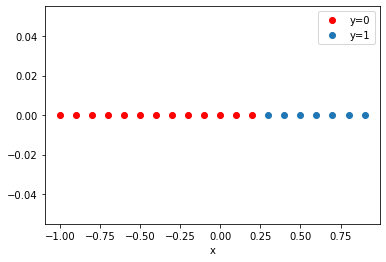

In [10]:
plt.plot(data_set.x[data_set.y==0], data_set.y[data_set.y==0], 'ro', label="y=0")
plt.plot(data_set.x[data_set.y==1], data_set.y[data_set.y==1]-1, 'o', label="y=1")
plt.xlabel('x')
plt.legend()

<h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>


For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.


We will create a custom class that defines the architecture of Logistic Regression using PyTorch. Logistic Regression has a single layer where the input is the number of features an X value of the dataset has (dimension of X) and there is a single output. The output of the layer is put into a sigmoid function which is a function between 0 and 1. The larger the output of the layer the closer it is to 1 and the smaller the output is the closer it is to 0. The sigmoid function will allow us to turn this output into a classification problem. If the output value is closer to 1 it is one class if it is closer to 0 it is in another.


Sigmoid Function

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/labs/Module3/Logistic-curve.svg)


In [11]:
#Create logistic regression class that inherits Nurel Network. Which is the base class for all neural network.
class logistic_regression(nn.Module):
    #constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)  # Single layer of Logistic Regression with number of inputs being n_inputs and there being 1 output 
    def forward(self, x): # Using the input x value puts it through the single layer defined above then puts the output through the sigmoid function and returns the result
        yhat = torch.sigmoid(self.linear(x))
        return yhat
        
        

In [12]:
x,y = data_set[0]
len(x)

1

In [13]:
#logistic Regression result
model = logistic_regression(1)

In [14]:
#We can make a prediction sigma  𝜎 , this uses the forward function defined above.
x = torch.tensor([-1.0])
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

Create a <code>plot_error_surfaces</code> object to visualize the data space and the learnable parameters space during training:

We can see on the Loss Surface graph, the loss value varying across w and b values with yellow being high loss and dark blue being low loss which is what we want

On the Loss Surface Contour graph we can see a top-down view of the Loss Surface graph


<Figure size 432x288 with 0 Axes>

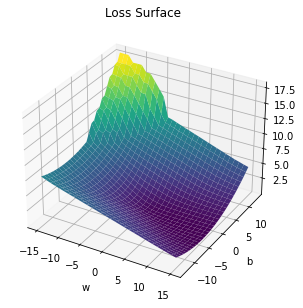

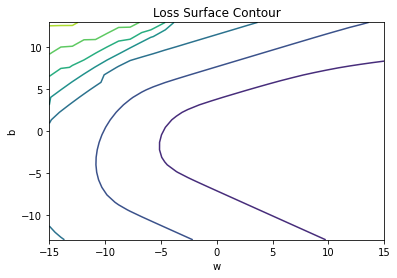

In [15]:
# Create the plot_error_surfaces object

# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

#Purpose:
#This is not a prediction or actual result. It is a tool to visualize the loss surface (error) for various combinations of weights and biases during training. 
#It helps understand how the model's parameters affect the error.

We define a criterion using Binary Cross Entropy Loss. This will measure the difference/loss between the prediction and actual value.

In [16]:
criterion= nn.BCELoss()

In [17]:
x, y = data_set[0]
print("x= {}, y={}".format(x,y))   #Our sample

x= tensor([-1.]), y=tensor([0.])


In [18]:
#Prediction
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [19]:
loss = criterion(sigma, y)
loss

tensor(1.0016, grad_fn=<BinaryCrossEntropyBackward0>)

**Setting the Batch Size using a Data Loader**

Using data loader in PyTorch that will output a batch of data, the input is the 'dataset' and 'batch size'

In [20]:
batch_size = 10
trainloader = DataLoader(dataset = data_set, batch_size = 10)
dataset_iter = iter(trainloader)
x,y = next(dataset_iter)
x

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

**Setting the Learning Rate**

We can set the learning rate by setting it as a parameter in the optimizer along with the parameters of the logistic regression model we are training. The job of the optimizer, torch.optim.SGD, is to use the loss generated by the criterion to update the model parameters according to the learning rate. SGD stands for Stochastic Gradient Descent which typically means that the batch size is set to 1, but the data loader we set up above has turned this into Mini-Batch Gradient Descent.

In [21]:
learning_rate = 0.1

In [22]:
Optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

**Train the Model via Mini-Batch Gradient Descent**

We are going to train the model using various Batch Sizes and Learning Rates.

**Mini-Batch Gradient Descent**

In this case, we will set the batch size of the data loader to 5 and the number of epochs to 250.

First, we must recreate the get_surface object again so that for each example we get a Loss Surface for that model only.

<Figure size 432x288 with 0 Axes>

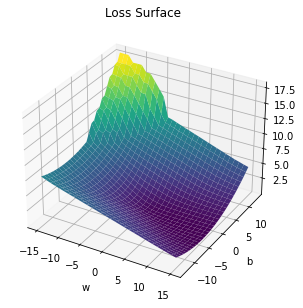

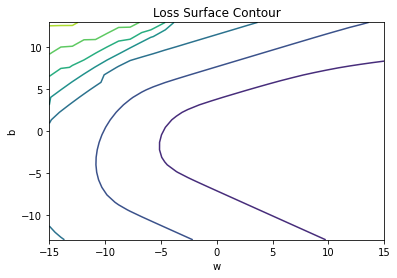

In [23]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

**Train the Model**

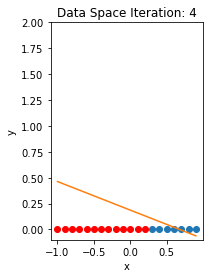

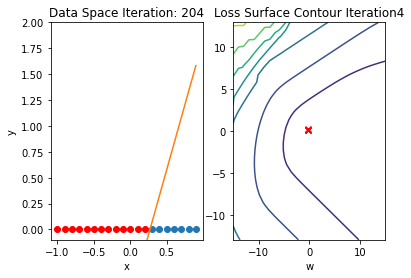

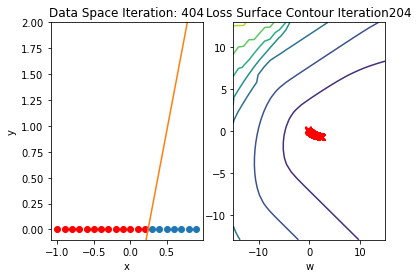

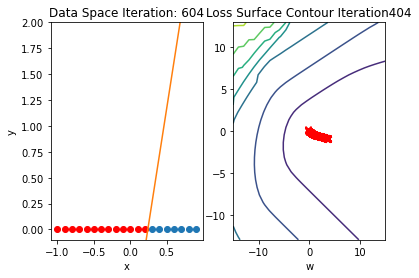

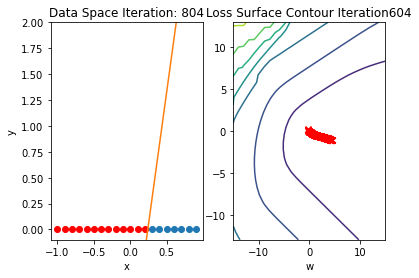

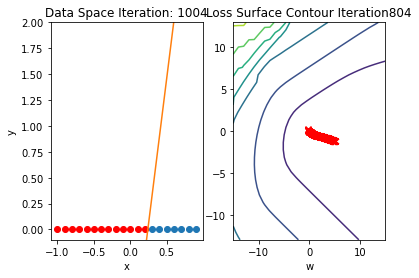

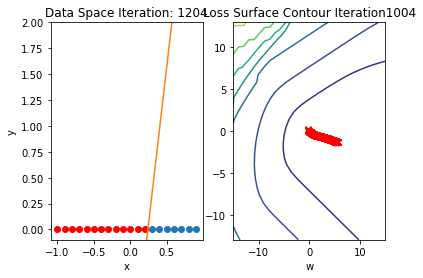

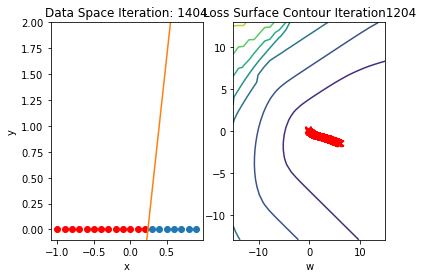

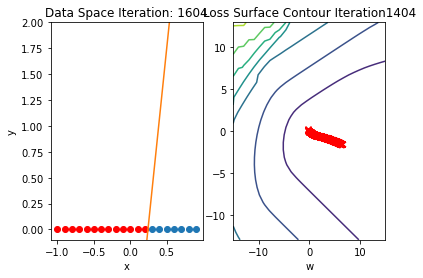

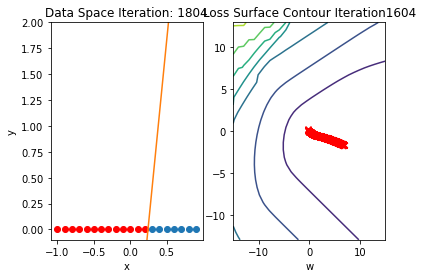

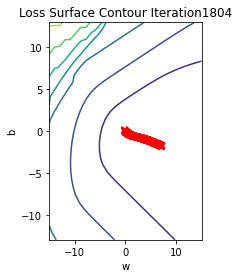

In [24]:
#First we create instane of the model we want to train
model = logistic_regression(1)
#Creating a criterion which will measure loss
criterion = nn.BCELoss()
#We create a data loader with the dataset and specified batch size of 5
trainloader = DataLoader(dataset=data_set, batch_size=5)
#We create an Optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#Then we set the number of epochs which is the total number of times we will train on the entire training dataset.
epochs=500
#This will store loss over iterations so we can plot it at the end.
loss_values=[]

#Loop to execute epochs
for epoch in range(epochs):
    #For each batch in the training data
    for x, y in trainloader:
        #Making our predictions on the x values
        yhat=model(x)
        #Measure the loss between prediction yhat and actual Y values
        loss=criterion(yhat, y)
        #Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        #Calculates the gradient value with respect to each weight and bias
        loss.backward()
        #Updates the weight and bias according to calculated gradient value
        optimizer.step()
        #Seting the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        #Save the loss of the iteration
        loss_values.append(loss)
    #Print the Data space for the current iteration every 50 epochs
    if epoch %50 == 0:
        get_surface.plot_ps()

In [25]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w=", w, "b=", b)

w= tensor([7.3966]) b= tensor(-1.7987)


Accuracy of the training data:

In [26]:
#Getting the predictions
yhat = model(data_set.x)
#Rounding the predictions, 0 or 1
yhat = torch.round(yhat)
correct=0
#Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    #Compares if the prediction and actual y  values are the same.
    if (prediction == actual):
        #Add to 'counter', if prediction is correct.
        correct+=1
#Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", (correct/len(data_set))*100, "%")

Accuracy:  100.0 %


Cost vs iteration gfraph:

Text(0, 0.5, 'Cost')

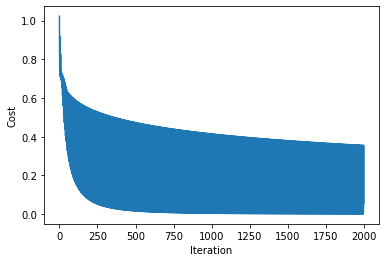

In [27]:
LOSS_BGD=[]
for i in loss_values: #loss depends on sigma & y
    LOSS_BGD.append(i.item())
    
plt.plot(LOSS_BGD)
plt.xlabel("Iteration")
plt.ylabel("Cost")


<Figure size 432x288 with 0 Axes>

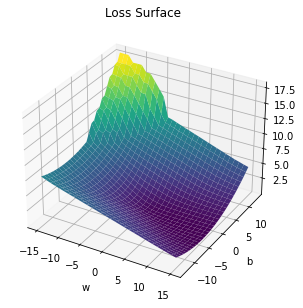

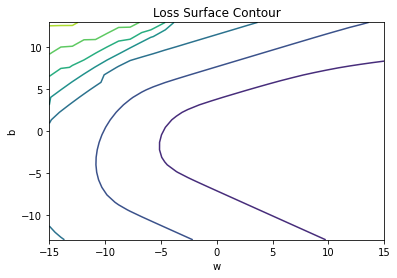

In [28]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

2.)

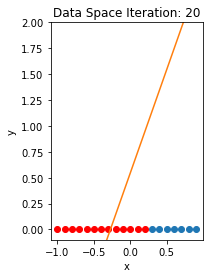

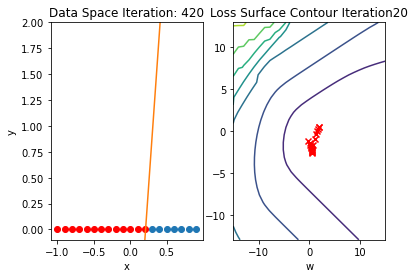

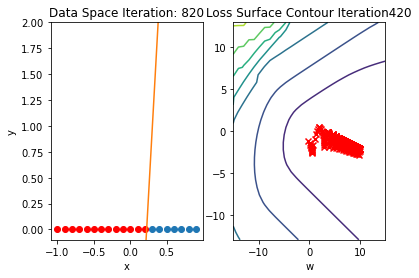

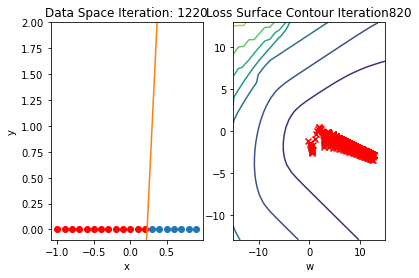

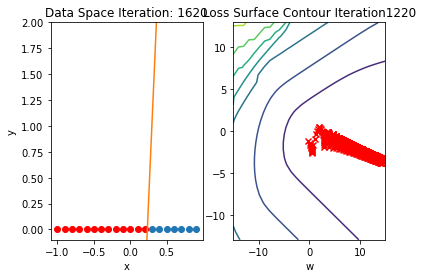

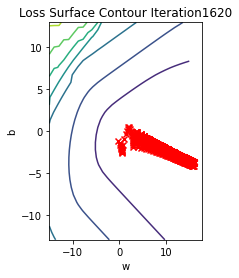

In [29]:
#First we create instane of the model we want to train
model = logistic_regression(1)
#Creating a criterion which will measure loss
criterion = nn.BCELoss()
#We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset=data_set, batch_size=1)
#We create an Optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1)
#Then we set the number of epochs which is the total number of times we will train on the entire training dataset.
epochs=100
#This will store loss over iterations so we can plot it at the end.
loss_values=[]

#Loop to execute epochs
for epoch in range(epochs):
    #For each batch in the training data
    for x, y in trainloader:
        #Making our predictions on the x values
        yhat=model(x)
        #Measure the loss between prediction yhat and actual Y values
        loss=criterion(yhat, y)
        #Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        #Calculates the gradient value with respect to each weight and bias
        loss.backward()
        #Updates the weight and bias according to calculated gradient value
        optimizer.step()
        #Seting the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        #Save the loss of the iteration
        loss_values.append(loss)
    #Print the Data space for the current iteration every 20 epochs
    if epoch %20 == 0:
        get_surface.plot_ps()

In [30]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([17.2923]) b =  tensor(-4.0826)


In [31]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

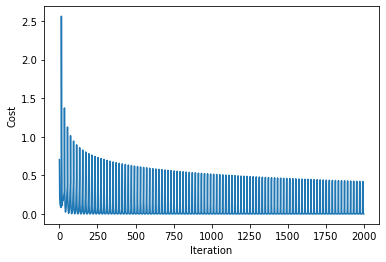

In [32]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())

 
plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")


3.)

Using the following code train the model using a learning rate of .01, 120 epochs, and batch_size of 1.

<Figure size 432x288 with 0 Axes>

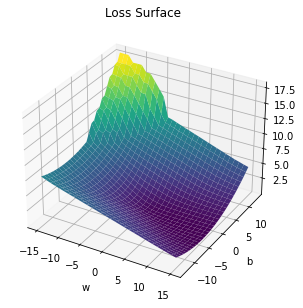

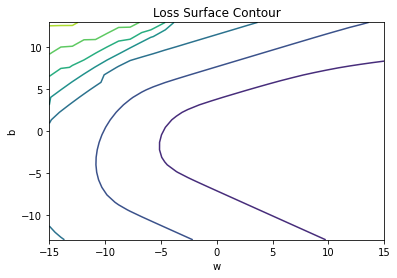

In [33]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

**Train the Model**

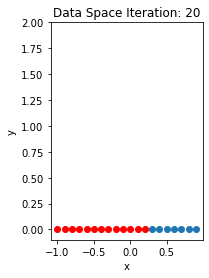

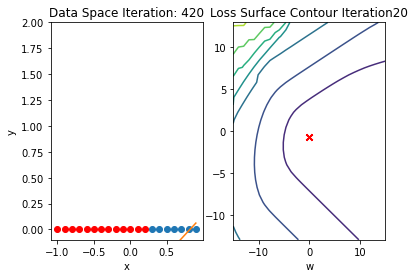

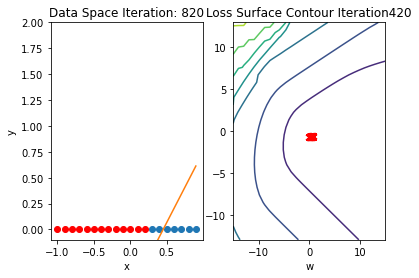

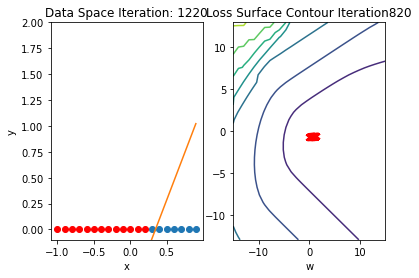

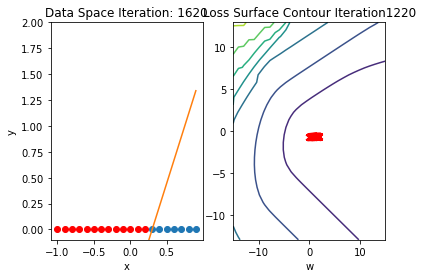

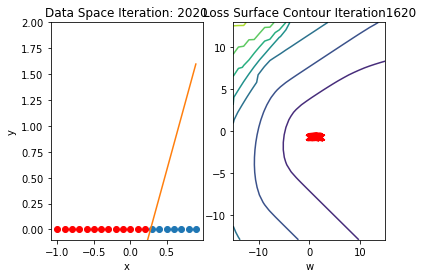

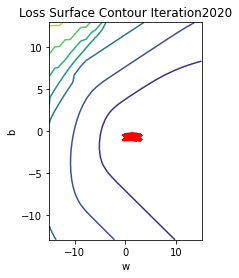

In [34]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs= 120
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [35]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.8387]) b =  tensor(-0.7510)


In [36]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

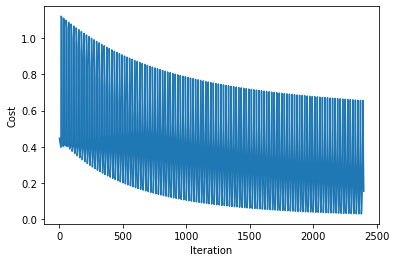

In [37]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())

 
plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")
